In [1]:
# Se implementan las librerias correspondientes para el comienzo del proyecto

import os
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
from pydub import AudioSegment
import subprocess
from moviepy.editor import VideoFileClip
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import cv2
import mediapipe as mp
import pandas as pd
import os

# Inicializa MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
landmarks_data = []

# Carpeta con las imágenes
images_folder = './Imagenes/'

# Definir los índices de los landmarks para las áreas de interés (valores aproximados)
CEJAS = list(range(70, 162))
OJOS = list(range(33, 133))
NARIZ = list(range(2, 35)) + list(range(362, 398))
BOCA = list(range(61, 146)) + list(range(287, 317))
AREAS_DE_INTERES = CEJAS + OJOS + NARIZ + BOCA

# Inicializa FaceMesh con las opciones deseadas
with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as face_mesh:

    # Lista todos los archivos en la carpeta de imágenes
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.jpg') or f.endswith('.png')]

    # Procesa cada imagen que cumple con el criterio
    for image_file in image_files:
        image_path = os.path.join(images_folder, image_file)
        image = cv2.imread(image_path)

        # Verifica si la imagen se cargó correctamente
        if image is None:
            print(f"No se pudo cargar la imagen {image_file}")
            continue

        # Cambia la resolución de la imagen y la convierte a RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Procesa la imagen para obtener los landmarks
        results = face_mesh.process(image_rgb)

        # Extrae landmarks faciales si están disponibles
        if results.multi_face_landmarks:
            # Cada imagen dará lugar a una sola fila con los landmarks de interés
            row = {'Image': image_file}
            for landmark_id in AREAS_DE_INTERES:
                landmark = results.multi_face_landmarks[0].landmark[landmark_id]
                # Añade las coordenadas x, y de cada landmark al diccionario de la fila
                row[f'K{landmark_id + 1}X'] = landmark.x
                row[f'K{landmark_id + 1}Y'] = landmark.y

            # Suponiendo que el nombre del archivo tiene la etiqueta de emoción después del primer '_'
            label = image_file.split('_')[1].upper()  # Esto toma el elemento después del primer '_'
            row['Label'] = label

            landmarks_data.append(row)

# Crea un DataFrame a partir de la lista de datos
df_landmarks_interes = pd.DataFrame(landmarks_data)

# Muestra los primeros registros del DataFrame
print(df_landmarks_interes.head())

# Opcional: Guarda el DataFrame a un archivo CSV
# df_landmarks_interes.to_csv('landmarks_interes_images_with_label.csv', index=False)


                                    Image      K71X      K71Y      K72X  \
0    SUJETO10_ENOJO_segmentado_frame0.jpg  0.428361  0.574431  0.420226   
1  SUJETO10_ENOJO_segmentado_frame120.jpg  0.437414  0.573397  0.428008   
2  SUJETO10_ENOJO_segmentado_frame150.jpg  0.435911  0.573990  0.425869   
3  SUJETO10_ENOJO_segmentado_frame180.jpg  0.434727  0.574767  0.425223   
4  SUJETO10_ENOJO_segmentado_frame210.jpg  0.436674  0.575793  0.427581   

       K72Y      K73X      K73Y      K74X      K74Y      K75X  ...     K313Y  \
0  0.552848  0.502121  0.867193  0.489370  0.867026  0.479501  ...  0.889418   
1  0.552844  0.507690  0.876897  0.495185  0.875914  0.485526  ...  0.900234   
2  0.552730  0.506445  0.872958  0.493570  0.872048  0.483685  ...  0.896833   
3  0.556985  0.505343  0.872785  0.492724  0.871544  0.482973  ...  0.896971   
4  0.555477  0.508074  0.873037  0.495268  0.872098  0.485483  ...  0.896949   

      K314X     K314Y     K315X     K315Y     K316X     K316Y     K3

In [3]:
df_landmarks_interes

,Image,K71X,K71Y,K72X,K72Y,K73X,K73Y,K74X,K74Y,K75X,...,K313Y,K314X,K314Y,K315X,K315Y,K316X,K316Y,K317X,K317Y,Label
0,SUJETO10_ENOJO_segmentado_frame0.jpg,0.428361,0.574431,0.420226,0.552848,0.502121,0.867193,0.489370,0.867026,0.479501,...,0.889418,0.523651,0.944821,0.525568,0.930163,0.526110,0.915337,0.526188,0.901367,ENOJO
1,SUJETO10_ENOJO_segmentado_frame120.jpg,0.437414,0.573397,0.428008,0.552844,0.507690,0.876897,0.495185,0.875914,0.485526,...,0.900234,0.529986,0.956800,0.530409,0.941877,0.531144,0.926512,0.531441,0.912058,ENOJO
2,SUJETO10_ENOJO_segmentado_frame150.jpg,0.435911,0.573990,0.425869,0.552730,0.506445,0.872958,0.493570,0.872048,0.483685,...,0.896833,0.528451,0.950848,0.529439,0.938299,0.530185,0.923543,0.530456,0.909827,ENOJO
3,SUJETO10_ENOJO_segmentado_frame180.jpg,0.434727,0.574767,0.425223,0.556985,0.505343,0.872785,0.492724,0.871544,0.482973,...,0.896971,0.528079,0.951674,0.528297,0.937464,0.529050,0.922363,0.529346,0.908239,ENOJO
4,SUJETO10_ENOJO_segmentado_frame210.jpg,0.436674,0.575793,0.427581,0.555477,0.508074,0.873037,0.495268,0.872098,0.485483,...,0.896949,0.529897,0.952229,0.531031,0.937664,0.531770,0.923007,0.532024,0.909292,ENOJO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,SUJETO9_TRISTEZA_segmentado_frame90.jpg,0.367699,0.538663,0.358855,0.522453,0.450478,0.795702,0.436877,0.796418,0.426764,...,0.811414,0.478100,0.904817,0.477679,0.871170,0.477940,0.858482,0.477662,0.846748,TRISTEZA
469,SUJETOBASELINE_ENOJO_.jpg,0.412025,0.467697,0.406427,0.462864,0.540046,0.695862,0.521668,0.701657,0.509205,...,0.717457,0.561031,0.814599,0.581225,0.752635,0.581338,0.738873,0.580346,0.725817,ENOJO
470,SUJETOBASELINE_FELICIDAD_.jpg,0.398645,0.423017,0.390783,0.423350,0.517791,0.704190,0.497586,0.708729,0.483375,...,0.729224,0.560013,0.797807,0.559422,0.766118,0.559231,0.751463,0.558878,0.738695,FELICIDAD
471,SUJETOBASELINE_NEUTRAL_.jpg,0.376788,0.343767,0.371540,0.354281,0.501405,0.608562,0.480843,0.619249,0.466052,...,0.637672,0.539420,0.720986,0.541301,0.679661,0.541114,0.662125,0.540563,0.647344,NEUTRAL


In [5]:
df_landmarks_interes.to_csv('interes_landmarks_images_with_label.csv', index=False)

In [6]:
csv_file_path = 'interes_landmarks_images_with_label.csv'
df = pd.read_csv(csv_file_path)

# Muestra las primeras 5 filas del DataFrame para verificar que se haya leído correctamente.
print(df.head())

                                    Image      K71X      K71Y      K72X  \
0    SUJETO10_ENOJO_segmentado_frame0.jpg  0.428361  0.574431  0.420226   
1  SUJETO10_ENOJO_segmentado_frame120.jpg  0.437414  0.573397  0.428008   
2  SUJETO10_ENOJO_segmentado_frame150.jpg  0.435911  0.573990  0.425869   
3  SUJETO10_ENOJO_segmentado_frame180.jpg  0.434727  0.574767  0.425223   
4  SUJETO10_ENOJO_segmentado_frame210.jpg  0.436674  0.575793  0.427581   

       K72Y      K73X      K73Y      K74X      K74Y      K75X  ...     K313Y  \
0  0.552848  0.502121  0.867193  0.489370  0.867026  0.479501  ...  0.889418   
1  0.552844  0.507690  0.876897  0.495185  0.875914  0.485526  ...  0.900234   
2  0.552730  0.506445  0.872958  0.493570  0.872048  0.483685  ...  0.896833   
3  0.556985  0.505343  0.872785  0.492724  0.871544  0.482973  ...  0.896971   
4  0.555477  0.508074  0.873037  0.495268  0.872098  0.485483  ...  0.896949   

      K314X     K314Y     K315X     K315Y     K316X     K316Y     K3

In [7]:
X = df.iloc[:, 1:-1]
Y = df.iloc[:, -1]

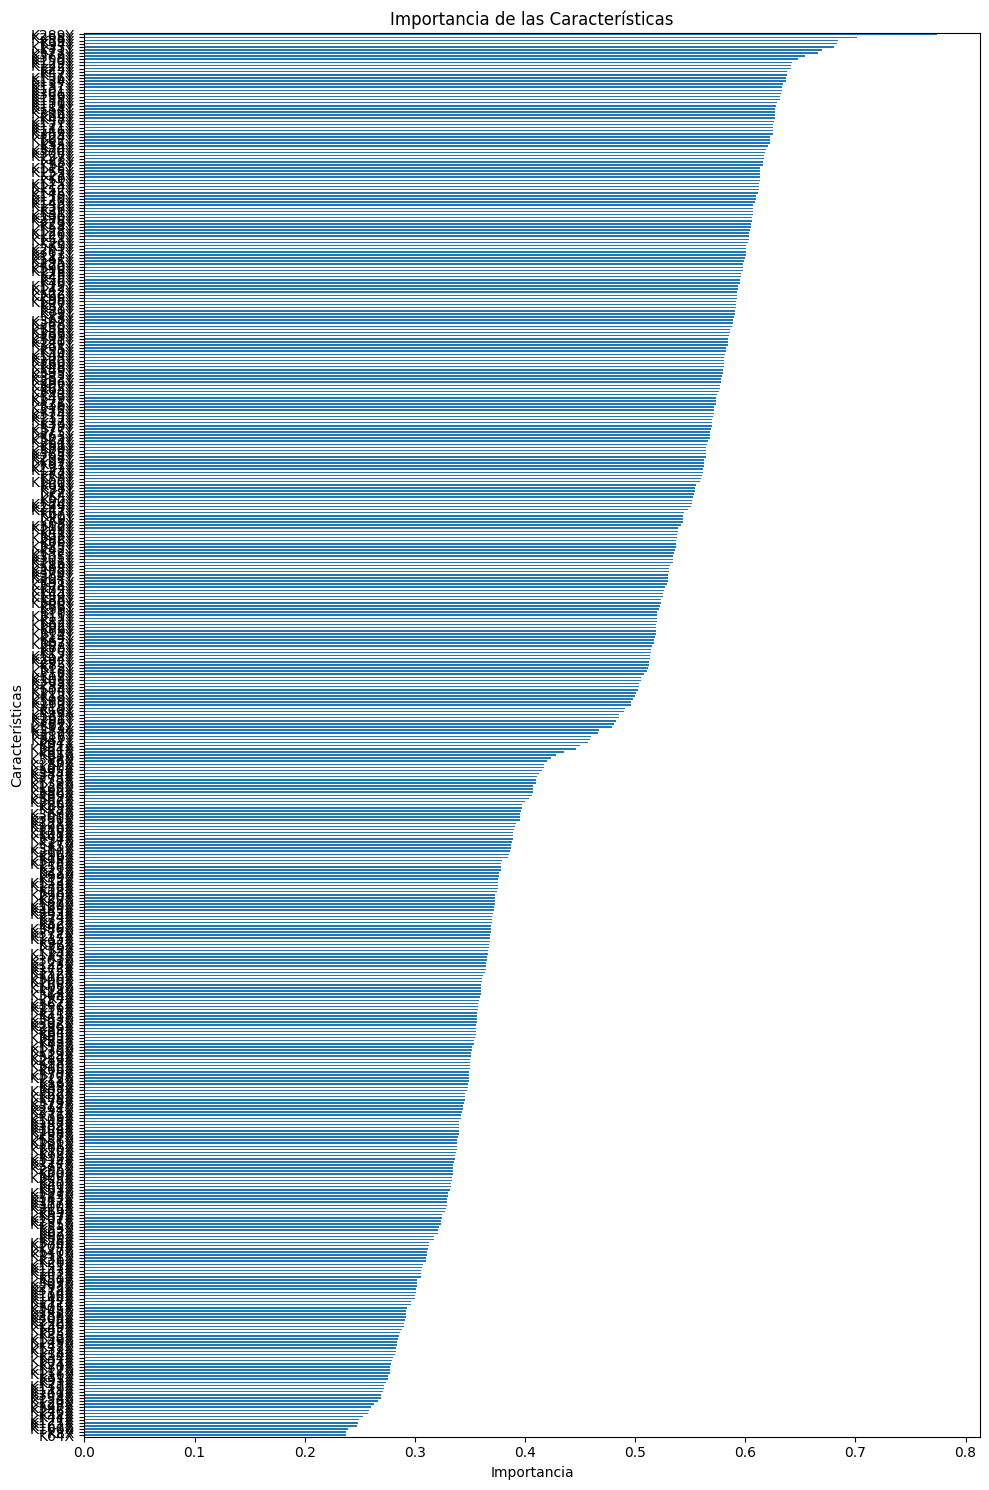

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Suponiendo que X y Y ya están definidos y son tu conjunto de datos y etiquetas, respectivamente
X_new = mutual_info_classif(X, Y)

# Ajusta las etiquetas de las columnas para que coincidan con las dimensiones de X
feat_imp = pd.Series(X_new, df.columns[1:len(df.columns)-1])

# Ordena las características por importancia y grafica
feat_imp_sorted = feat_imp.sort_values()

# Graficar la importancia de las características
plt.figure(figsize=(10, 15))  # Ajusta el tamaño según sea necesario
feat_imp_sorted.plot(kind='barh')

# Rotar las etiquetas
plt.gca().tick_params(axis='y', labelrotation=0)  # Cambia a 45 o 90 si es necesario

# Mejora la legibilidad del gráfico
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.tight_layout()  # Asegura que todo encaje sin superponerse

plt.show()


In [9]:
# Calcular el valor medio entre 0.4 y 0.5
umbral = (0.4 + 0.5) / 2

# Filtrar las características con valores mayores al umbral
selected_features = df.columns[np.where(X_new > umbral)].tolist()

# Mostrar las características seleccionadas
print("Características seleccionadas con valor mayor a", umbral, ":", selected_features)
features_df_info_gain = df[["Image"] + selected_features]
features_df_info_gain

Características seleccionadas con valor mayor a 0.45 : ['K71X', 'K72X', 'K73X', 'K74X', 'K75X', 'K76X', 'K77X', 'K78X', 'K79X', 'K80X', 'K81X', 'K82X', 'K83X', 'K84X', 'K85X', 'K86X', 'K87X', 'K88X', 'K89X', 'K90X', 'K91X', 'K92X', 'K93X', 'K93Y', 'K94X', 'K95X', 'K96X', 'K97X', 'K98X', 'K99X', 'K100X', 'K101X', 'K102X', 'K103X', 'K104X', 'K105X', 'K106X', 'K107X', 'K108X', 'K109X', 'K110X', 'K111X', 'K112X', 'K113X', 'K114X', 'K115X', 'K116X', 'K117X', 'K118X', 'K119X', 'K120X', 'K121X', 'K122X', 'K123X', 'K124X', 'K125X', 'K126X', 'K127X', 'K128X', 'K129X', 'K130X', 'K131X', 'K132X', 'K132Y', 'K133X', 'K134X', 'K135X', 'K136X', 'K137X', 'K138X', 'K139X', 'K140X', 'K141X', 'K142X', 'K143X', 'K144X', 'K145X', 'K146X', 'K147X', 'K148X', 'K149X', 'K150X', 'K151X', 'K152X', 'K153X', 'K154X', 'K155X', 'K156X', 'K157X', 'K158X', 'K159X', 'K160X', 'K161X', 'K162X', 'K34X', 'K35X', 'K36X', 'K37X', 'K38X', 'K39X', 'K40X', 'K41X', 'K42X', 'K43X', 'K44X', 'K45X', 'K46X', 'K47X', 'K48X', 'K49X', 

,Image,K71X,K72X,K73X,K74X,K75X,K76X,K77X,K78X,K79X,...,K308X,K309X,K310X,K311X,K312X,K313X,K314X,K315X,K316X,K317X
0,SUJETO10_ENOJO_segmentado_frame0.jpg,0.428361,0.420226,0.502121,0.489370,0.479501,0.498008,0.465469,0.470695,0.468233,...,0.554629,0.557667,0.545505,0.543920,0.535604,0.525751,0.523651,0.525568,0.526110,0.526188
1,SUJETO10_ENOJO_segmentado_frame120.jpg,0.437414,0.428008,0.507690,0.495185,0.485526,0.505771,0.471801,0.476875,0.474560,...,0.560480,0.563805,0.555178,0.549841,0.541345,0.531266,0.529986,0.530409,0.531144,0.531441
2,SUJETO10_ENOJO_segmentado_frame150.jpg,0.435911,0.425869,0.506445,0.493570,0.483685,0.503520,0.469811,0.475041,0.472501,...,0.559354,0.562626,0.552903,0.548866,0.540402,0.530301,0.528451,0.529439,0.530185,0.530456
3,SUJETO10_ENOJO_segmentado_frame180.jpg,0.434727,0.425223,0.505343,0.492724,0.482973,0.503644,0.469203,0.474364,0.471922,...,0.558452,0.561829,0.552935,0.547773,0.539210,0.529052,0.528079,0.528297,0.529050,0.529346
4,SUJETO10_ENOJO_segmentado_frame210.jpg,0.436674,0.427581,0.508074,0.495268,0.485483,0.505555,0.471714,0.476873,0.474434,...,0.560537,0.563726,0.554987,0.550145,0.541818,0.531801,0.529897,0.531031,0.531770,0.532024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,SUJETO9_TRISTEZA_segmentado_frame90.jpg,0.367699,0.358855,0.450478,0.436877,0.426764,0.442108,0.412683,0.417781,0.415820,...,0.508123,0.511065,0.495321,0.497528,0.489122,0.478353,0.478100,0.477679,0.477940,0.477662
469,SUJETOBASELINE_ENOJO_.jpg,0.412025,0.406427,0.540046,0.521668,0.509205,0.497168,0.496127,0.504561,0.500203,...,0.618919,0.622382,0.561520,0.603350,0.591542,0.577166,0.561031,0.581225,0.581338,0.580346
470,SUJETOBASELINE_FELICIDAD_.jpg,0.398645,0.390783,0.517791,0.497586,0.483375,0.504741,0.467120,0.475562,0.471560,...,0.605143,0.610011,0.578031,0.589117,0.574995,0.558191,0.560013,0.559422,0.559231,0.558878
471,SUJETOBASELINE_NEUTRAL_.jpg,0.376788,0.371540,0.501405,0.480843,0.466052,0.488175,0.450025,0.459107,0.454250,...,0.582275,0.586783,0.556786,0.568250,0.555334,0.539578,0.539420,0.541301,0.541114,0.540563


In [10]:
X= features_df_info_gain.iloc[:, 1:-1]

In [11]:
encoder = LabelEncoder()
y_encode = encoder.fit_transform(Y)
y_encode

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [12]:
names = [
    "Nearest Neighbors",
    "Naive Bayes",
    "AdaBoost",
    "Gradient Boosting",
    "Random Forest"
]
modelos = [
    KNeighborsClassifier(n_neighbors=6),
    GaussianNB(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=24)
]

In [13]:
def validacion_cruzada(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracies = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        X_test_np = X_test.values
        y_pred = model.predict(X_test_np)

        precision = precision_score(y_test, y_pred, average='weighted')
        precision_scores.append(precision)

        recall = recall_score(y_test, y_pred, average='weighted')
        recall_scores.append(recall)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)

    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(accuracies)

resultados = []

for nombre, modelo in zip(names, modelos):
    precision, recall, f1, accuracy = validacion_cruzada(model=modelo, X=X, y=y_encode)
    resultados.append({"nombre": nombre, "precision": precision, "recall": recall, "f1_score": f1, "accuracy": accuracy})

df_resultados = pd.DataFrame(resultados)

In [14]:
df_resultados

,nombre,precision,recall,f1_score,accuracy
0,Nearest Neighbors,0.810395,0.799015,0.798841,0.799015
1,Naive Bayes,0.212584,0.283337,0.211375,0.283337
2,AdaBoost,0.302535,0.334087,0.247572,0.334087
3,Gradient Boosting,0.846254,0.837223,0.836870,0.837223
4,Random Forest,0.855804,0.847704,0.848327,0.847704


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encode, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=24)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

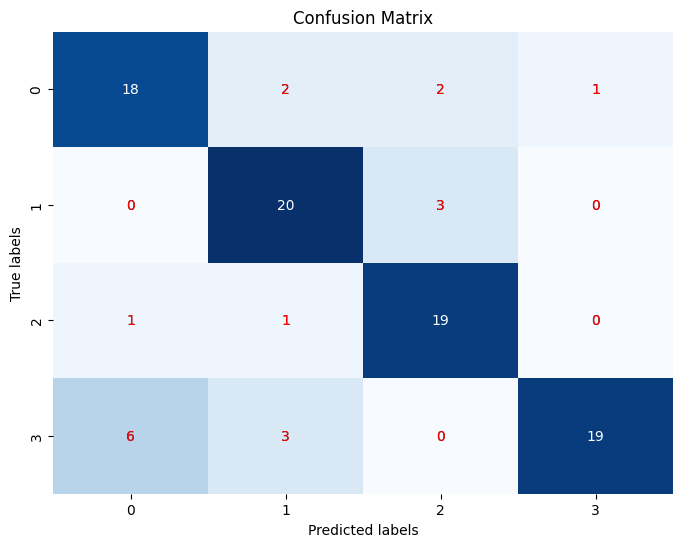

F1 Score: 0.7992158968850698
Sensibilidad (Recall): 0.8
Especificidad por clase: [0.9027777777777778, 0.9166666666666666, 0.9324324324324325, 0.9850746268656716]
Exactitud: 0.8


In [16]:
# Obtener predicciones del modelo
y_pred = model.predict(X_test)

# Calcular la matriz de confusión multiclase
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas adicionales
f1 = f1_score(y_test, y_pred, average='weighted')
sensibilidad = recall_score(y_test, y_pred, average='weighted')
exactitud = accuracy_score(y_test, y_pred)

# Calcular especificidad para cada clase
especificidad = []
for i in range(len(conf_matrix)):
    true_negative = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))
    total_negative = np.sum(np.delete(conf_matrix, i, 0))
    especificidad.append(true_negative / total_negative)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

# Resaltar los valores donde el modelo se confundió
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j:
            plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha="center", va="center", color="red")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Imprimir métricas
print("F1 Score:", f1)
print("Sensibilidad (Recall):", sensibilidad)
print("Especificidad por clase:", especificidad)
print("Exactitud:", exactitud)

In [18]:
# Imprime los nombres de las columnas para verificar su formato
print(df.columns.tolist()[:10])


['Image', 'K71X', 'K71Y', 'K72X', 'K72Y', 'K73X', 'K73Y', 'K74X', 'K74Y', 'K75X']


In [19]:
def draw_keypoints(image, row):
    for i in range(1, 469):
        # Construye los nombres de las columnas
        keypoint_x = f'x{i}'
        keypoint_y = f'y{i}'
        # Verifica si las columnas existen en el DataFrame
        if keypoint_x in row and keypoint_y in row:
            # Los keypoints están en las columnas 'x{i}' y 'y{i}'
            x = int(row[keypoint_x] * image.shape[1])
            y = int(row[keypoint_y] * image.shape[0])
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
    return image


In [27]:
import cv2
import mediapipe as mp
import os

# Inicializar MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)
drawing_spec = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)

# Carpeta con las imágenes
images_folder = './Imagenes/'

# Lista todos los archivos de imagen en la carpeta
image_files = [f for f in os.listdir(images_folder) if f.endswith('.jpg') or f.endswith('.png')]

# Procesa cada imagen
for image_file in image_files:
    image_path = os.path.join(images_folder, image_file)
    image = cv2.imread(image_path)

    # Verifica si la imagen fue cargada exitosamente
    if image is None:
        print(f"No se pudo cargar la imagen {image_file}")
        continue
    
    # Redimensionar la imagen a 720p (1280x720)
    image_720p = cv2.resize(image, (640, 480))
    
    # Convertir el color de BGR a RGB
    image_rgb = cv2.cvtColor(image_720p, cv2.COLOR_BGR2RGB)
    
    # Procesar la imagen con FaceMesh
    results = face_mesh.process(image_rgb)
    
    # Dibuja los landmarks faciales si están disponibles
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image=image_720p,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec)
    
    # Muestra la imagen redimensionada con los landmarks
    cv2.imshow('FaceMesh on Image', image_720p)
    
    # Espera a que se presione una tecla para continuar con la siguiente imagen
    key = cv2.waitKey(0)
    if key == 27:  # Salir con la tecla Esc
        print("Saliendo...")
        break

# Cierra todas las ventanas de OpenCV
cv2.destroyAllWindows()


Saliendo...
